
**Textúry** - povrch objektov má charakteristický vzor, ktorý sa určitým spôsobom opakuje, nazývaný textúra.

**Fourierova transformácia** - metóda, ktorá dokáže detekovať opakujúce sa objekty.  

Konvolúcia a Fourierova transformácia nie sú vhodné na detekciu textúr:

- Fourierovu transformáciu je potrebné aplikovať globálne na celý obraz, a ak sa textúra nachádza len na menšej časti obrazu, môže to spôsobiť problémy pri segmentácii.  

- Konvolúcia má štandardné problémy, ako napríklad, že pri hľadaní pomocou masky deteguje len to, čo sa nachádza v tejto maske.

Metódy na detekciu textúr sú založené na tzv. **konkurenčnej matici**:

- **Konkurenčná matica** je matica, ktorá zobrazuje početnosť rovnakých pixelov v okolí. Na základe tejto početnosti môže vypočítať rôzne metriky, ktoré nám poskytujú určité vlastnosti textúr.

- Vlastnosti týchto textúr zahŕňajú kontrast, homogenitu, dissimilaritu, ASM (angular second moment), energiu a koreláciu. Bolo by vhodné podrobnejšie opísať každú z týchto vlastností.

In [11]:
from skimage import data, color, io
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from skimage.color import label2rgb
from skimage.filters.rank import entropy
from skimage import morphology
from skimage.feature import graycomatrix, graycoprops
from skimage.segmentation import find_boundaries, mark_boundaries

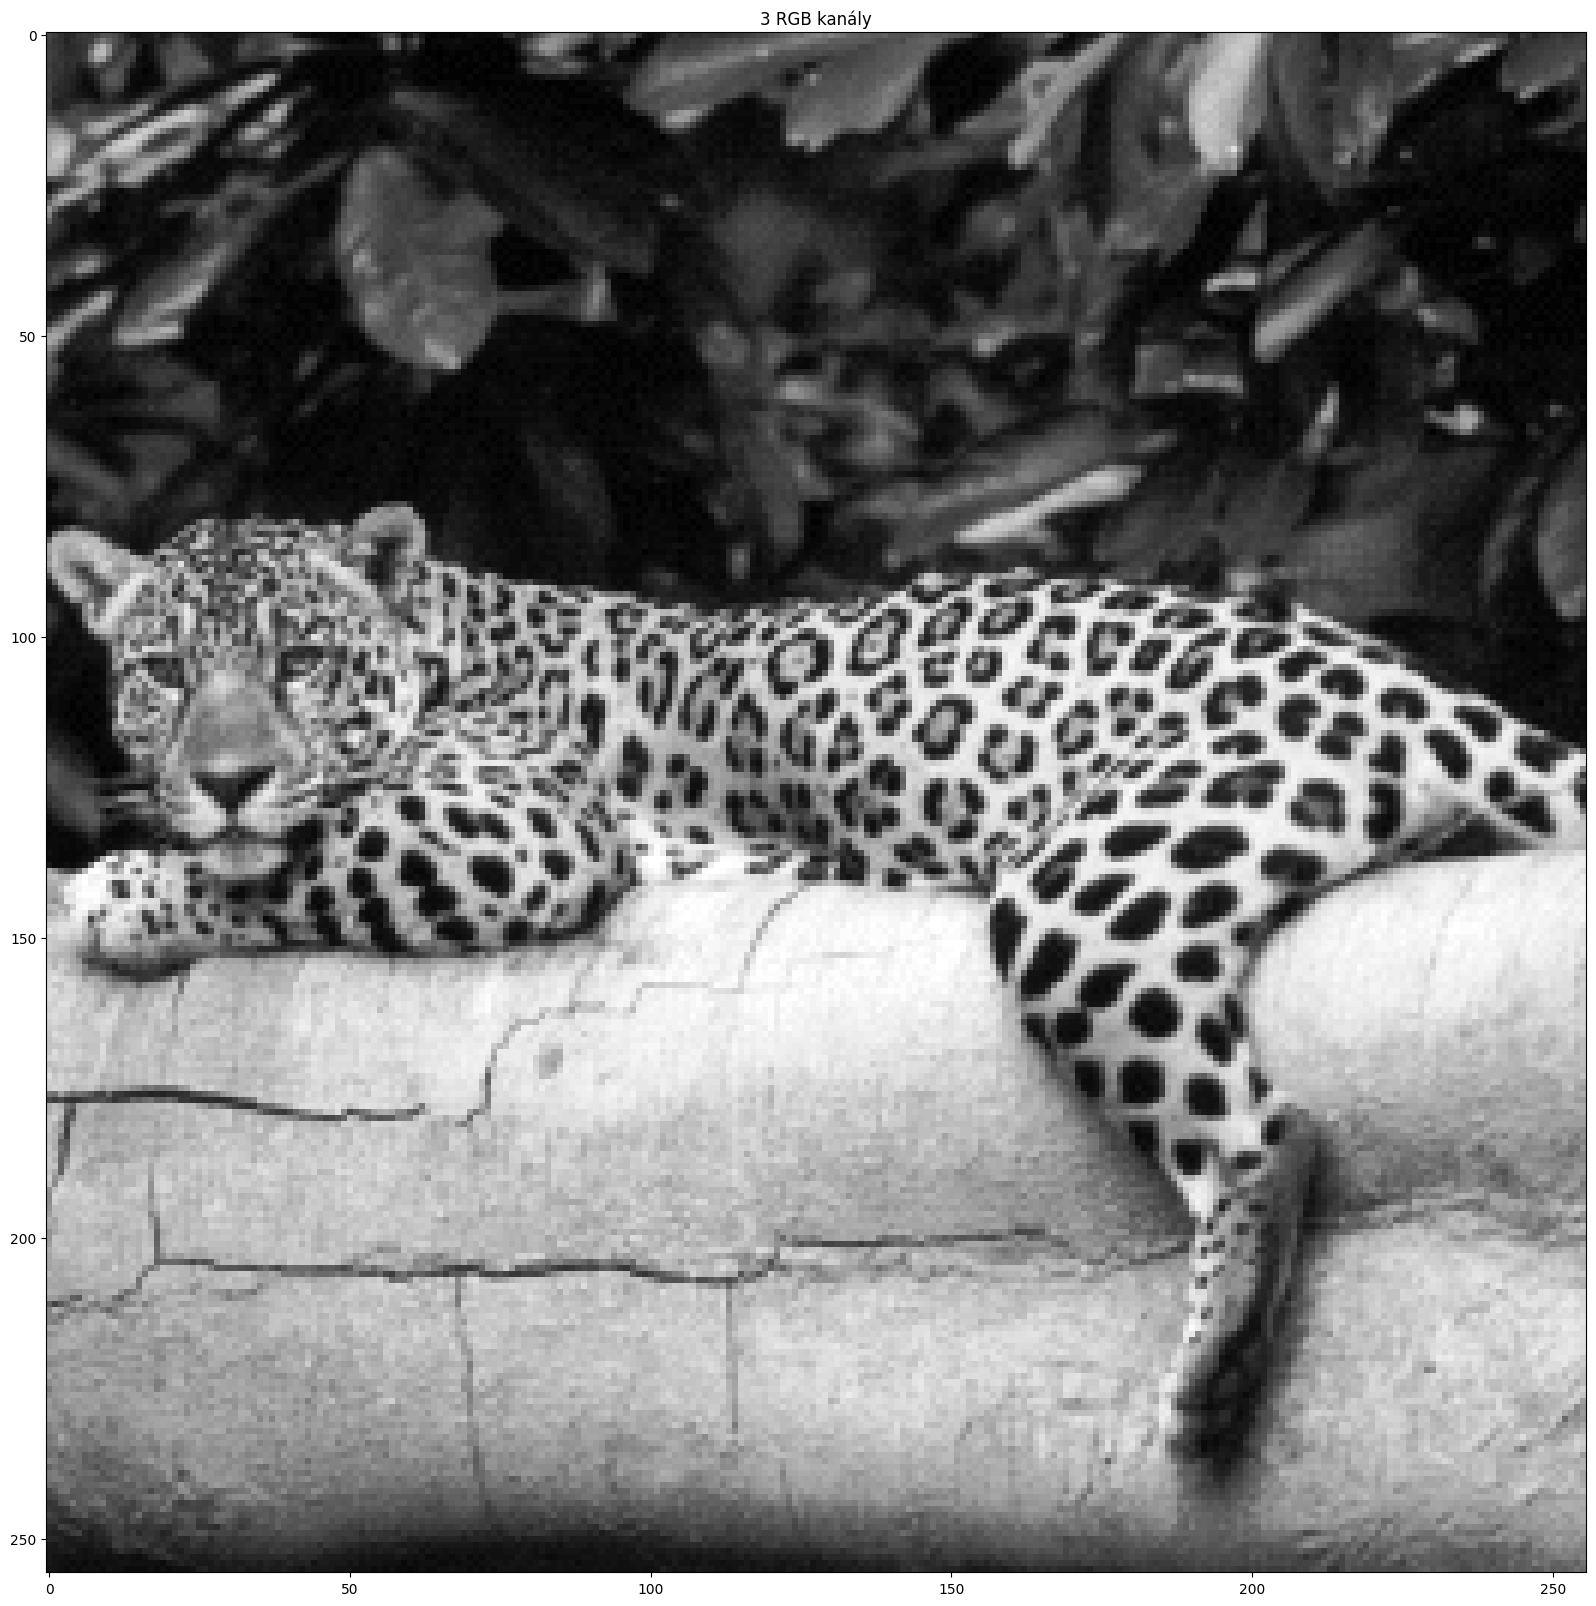

In [39]:
img = io.imread('/content/jaguar.gif')

img = (color.rgb2gray(img[..., 0:3])*255).astype(np.uint8)[0]
plt.figure(figsize= (20, 20))
plt.title('3 RGB kanály')
plt.imshow(img, cmap="gray")

Entropia je mierou náhodnosti v textúre. Čím je miera opakovania v textúre konzistentnejšia, tým je entropia vyššia. Vidíme jednotlivé textúry.

Text(0.5, 1.0, 'Entropia')

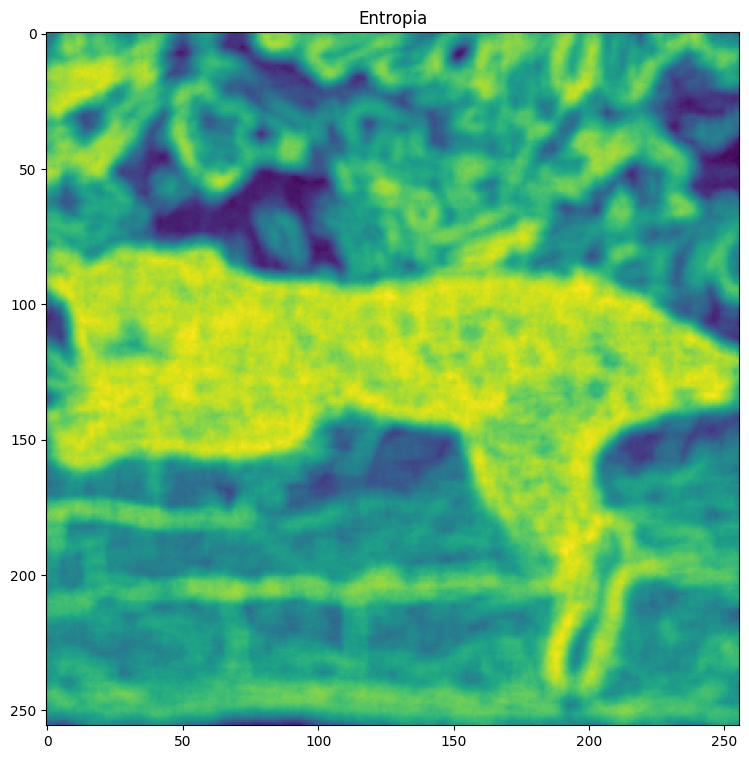

In [40]:
im_entropy = entropy(img, morphology.disk(5))
plt.figure(figsize=(9, 9))
plt.imshow(im_entropy)
plt.title('Entropia')

* Kontrast, rozdiel intenzitami jasu pixelu a jeho susedov v celom výreze. Kontrast je nulový pre konštantný obraz.
* Korelácia, štatistická miera závisloti hodnoty jasu pixelu od hodnôt jasov jeho susedov.
* Energia, určuje mieru usporiadanosti obrazu.
* Homogénnosť, kvalita určujúca mieru podobnosti rôznych oblastí obrazu.

In [41]:
# Initialize matrices to store texture properties
im_contrast = np.zeros(im_entropy.shape)
im_correlation = np.zeros(im_entropy.shape)
im_energy = np.zeros(im_entropy.shape)
im_homogeneity = np.zeros(im_entropy.shape)

The spacing of examined pixels, if not defined otherwise, is 0 rows and 1 column, i.e. the scaled brightness values of neighboring pixels in the horizontal direction are examined. We initialize these zero matrices with the dimension of the im_entropy array.

Now we will cycle through all the slices of the image. For each section, we calculate the co-occurrence matrix and the values of the monitored properties. We write these into the corresponding matrices.

In [42]:
# Extract a window from the grayscale image, where the size of the window is defined by window_size.
# Calculate the Gray-Level Co-occurrence Matrix (GLCM) for the window using greycomatrix from scikit-image.
# Calculate the specified texture properties (contrast, correlation, energy, homogeneity) from the GLCM using greycoprops.
# Store the calculated texture properties in the corresponding matrices (im_contrast, im_correlation, im_energy, im_homogeneity) at the appropriate location.
# The resulting matrices now contain the texture properties for different sections of the image, which you can use for further analysis or visualization.
# Ignore all warnings
import warnings
# Ignore DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning, module='skimage')

# Define the parameters for texture analysis
distances = [1]
angles = [0]
properties = ['contrast', 'correlation', 'energy', 'homogeneity']
window_size = 9

# Iterate through image slices to calculate texture properties
for i in tqdm(range(0, im_entropy.shape[0]-window_size)):
  for j in range(0, im_entropy.shape[1]-window_size):

    # Extract a window from the grayscale image
    window = img[i:i + window_size, j:j + window_size]

    # Calculate the gray-level co-occurrence matrix (GLCM) for the window
    glcm = graycomatrix(window,
                        distances=distances,
                        angles=angles,
                        symmetric=True,
                        normed=True)

    # Calculate and store texture properties in the corresponding matrices
    feats = np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])
    im_contrast[i, j] = feats[0]
    im_correlation[i, j] = feats[1]
    im_energy[i, j] = feats[2]
    im_homogeneity[i, j] = feats[3]

  0%|          | 0/247 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Homogeneity')

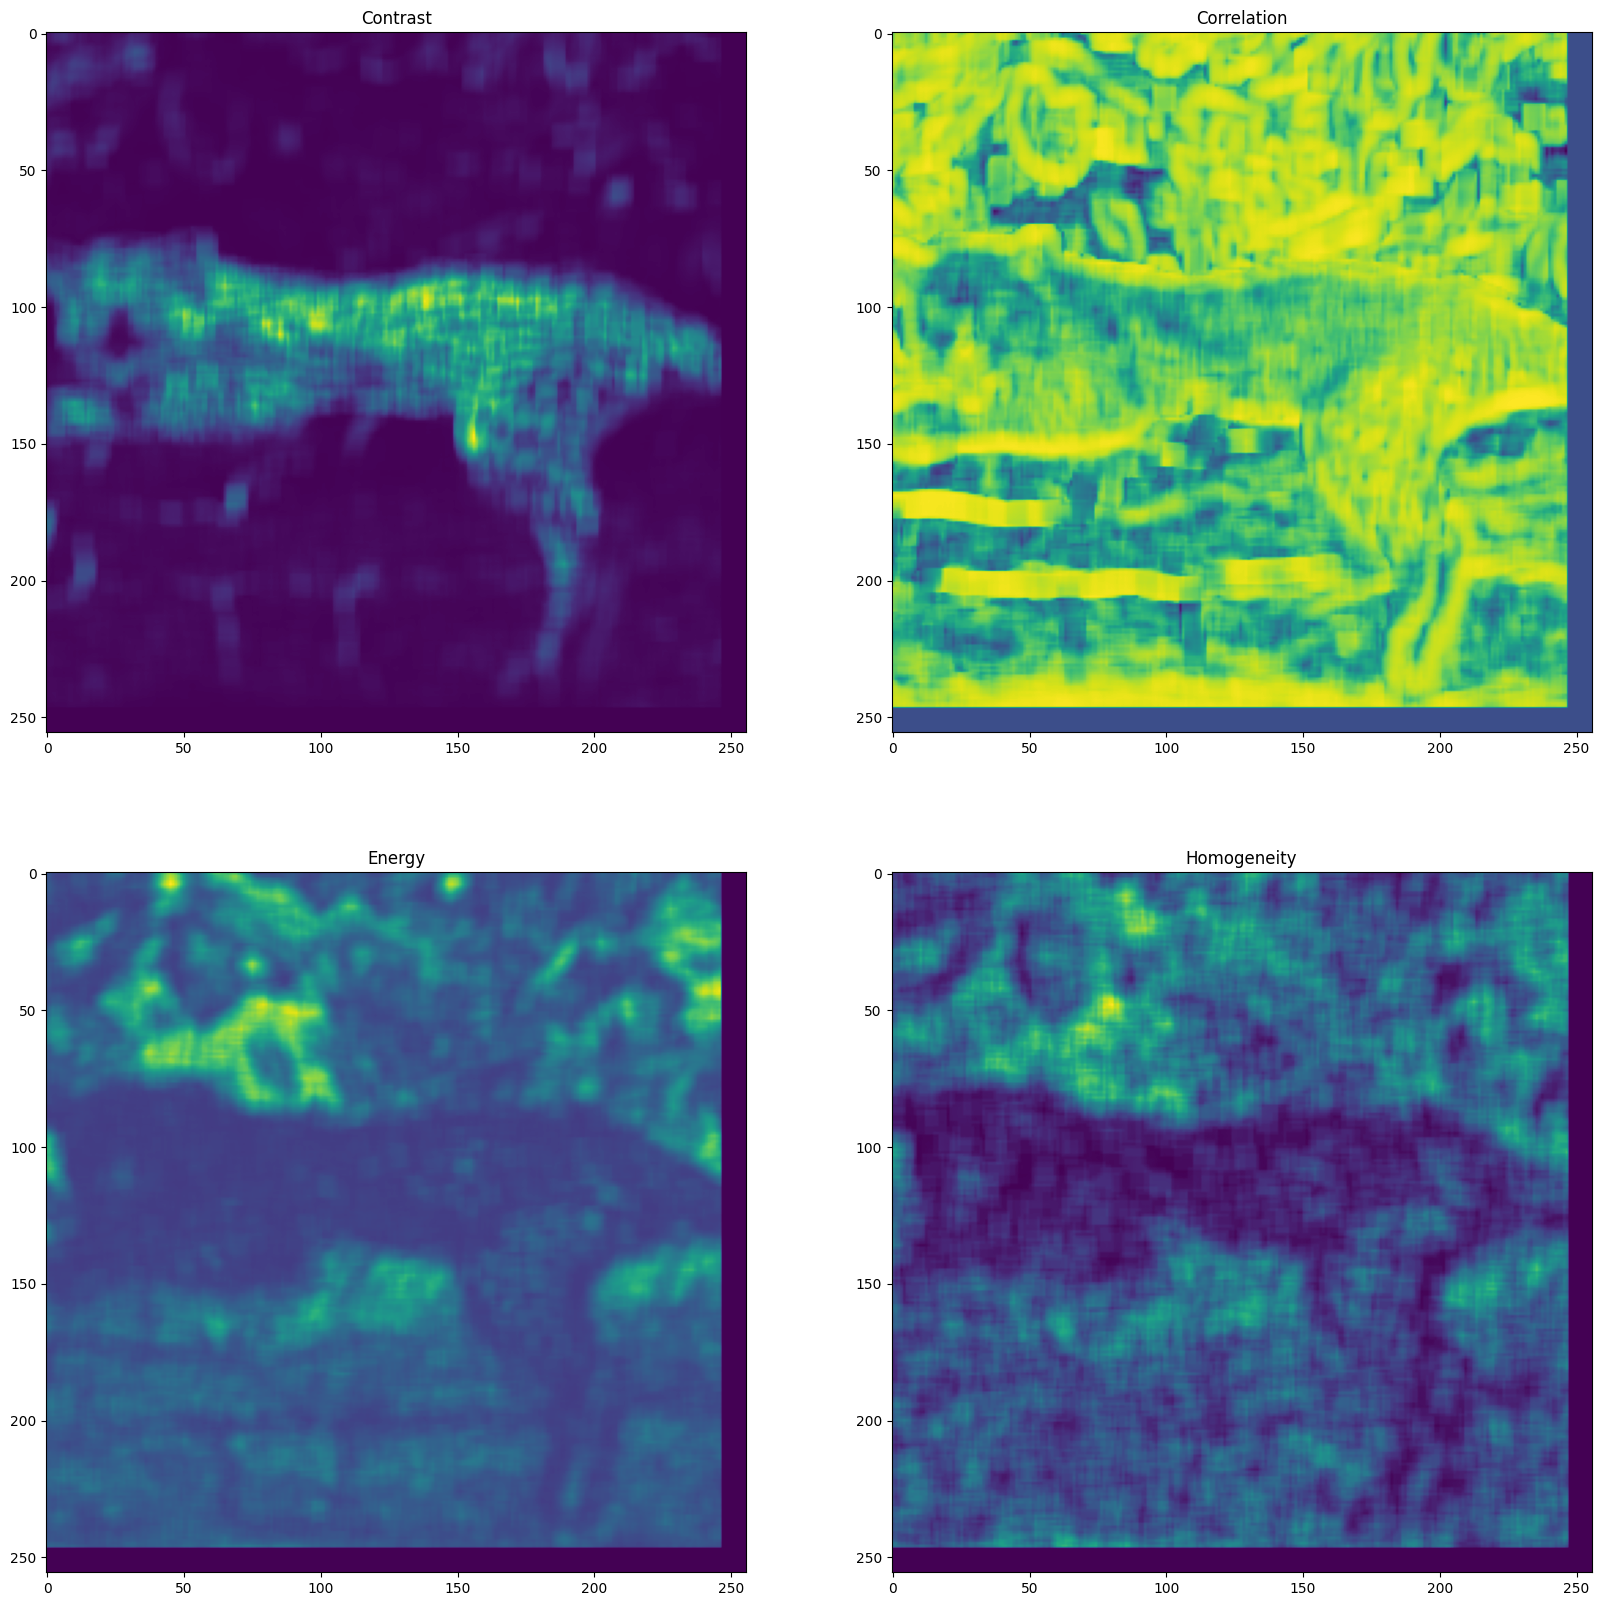

In [43]:
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(im_contrast)
plt.title('Contrast')

plt.subplot(222)
plt.imshow(im_correlation)
plt.title('Correlation')

plt.subplot(223)
plt.imshow(im_energy)
plt.title('Energy')

plt.subplot(224)
plt.imshow(im_homogeneity)
plt.title('Homogeneity')

1. **Kontrast** je klasicky najvyšší tam, kde je najväčší rozdiel medzi bielou a čiernou, čo znamená, že prechod z čiernej na bielu predstavuje najvyššiu mieru kontrastu.

2. **Korelácia** vyjadruje určitú závislosť prechodov, a tam, kde sú hrany výraznejšie, je vyššia.

3. **Homogenita** - čím vyššia, tým je obraz konzistentnejší. Tam, kde je viac konzistencie a textúra je menej výrazná, je aj homogenita vyššia.

4. **Energia** - čím vyššia je energia, tým viac je obraz konzistentný.

Text(0.5, 1.0, 'Plot of dispersion')

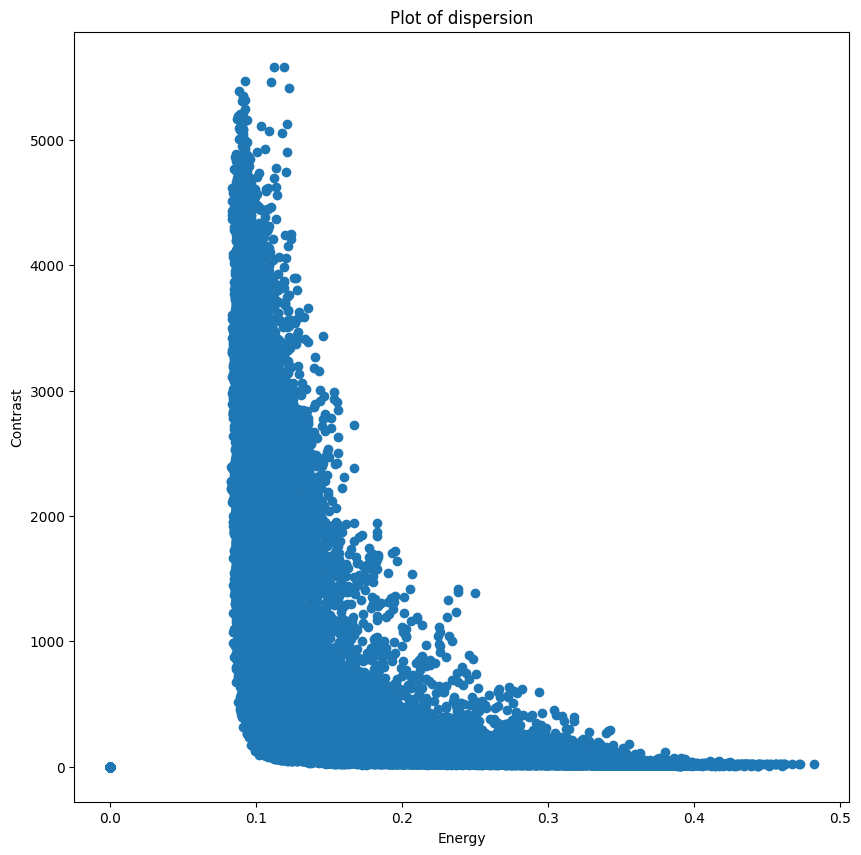

In [44]:
plt.figure(figsize=(10, 10))
plt.scatter(im_energy.ravel(), im_contrast.ravel())
plt.xlabel('Energy')
plt.ylabel('Contrast')
plt.title('Plot of dispersion')

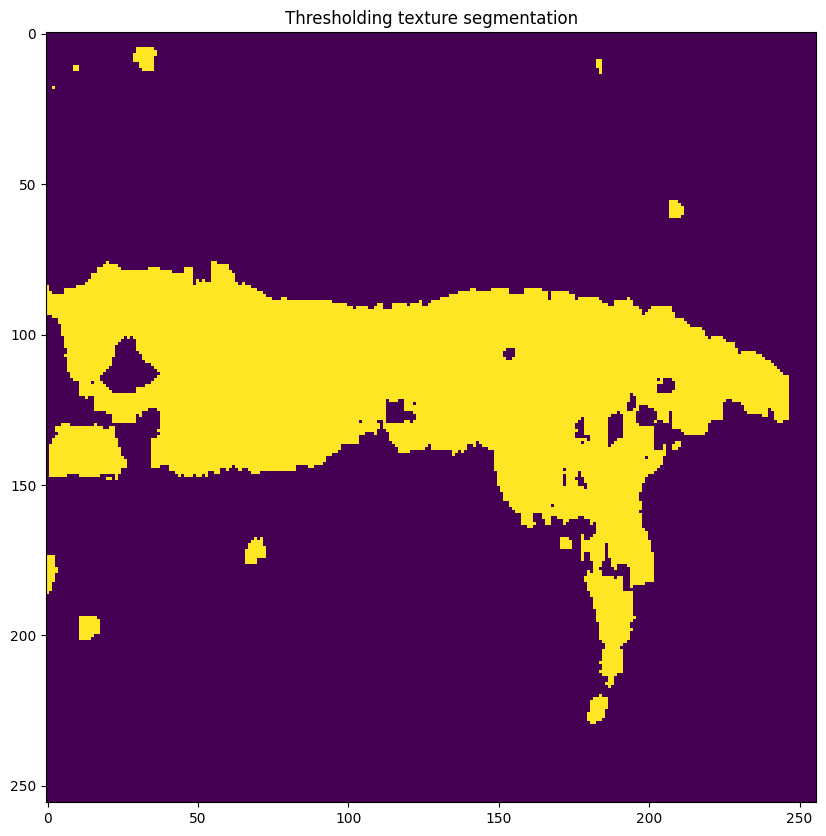

In [49]:
plt.figure(figsize=(10, 10))
plt.title('Thresholding texture segmentation')
plt.imshow(np.logical_and(im_energy<0.15, im_contrast>1000))

## Autonomous task 1

Improve the quality of segmentation by thresholding on the image of a jaguar e.g. by applying Gaussian blur, changing the way attributes are calculated, or in any other way.

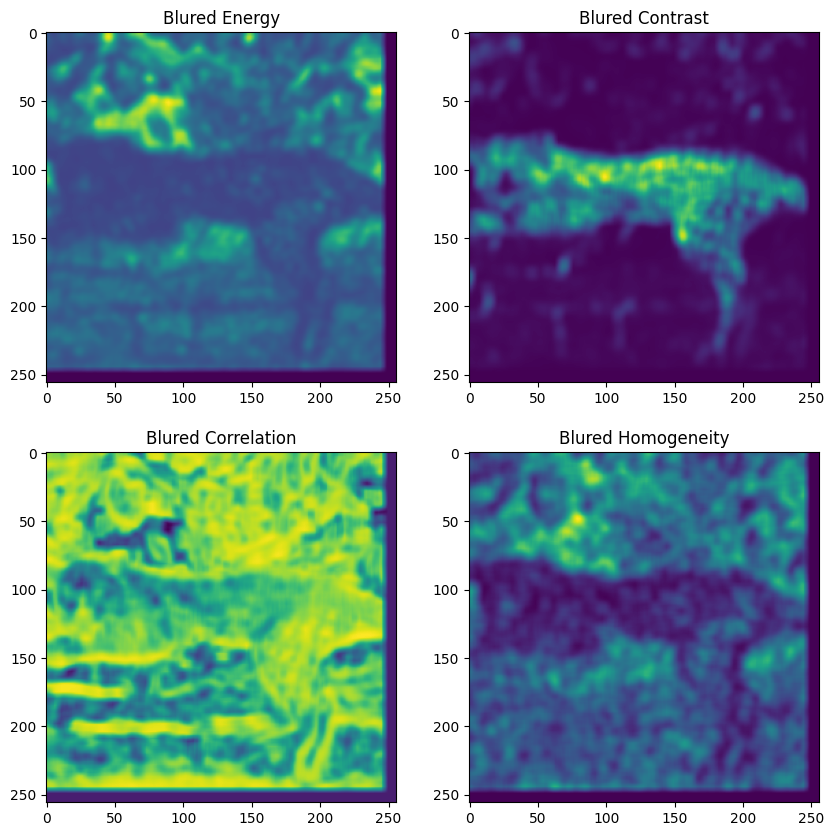

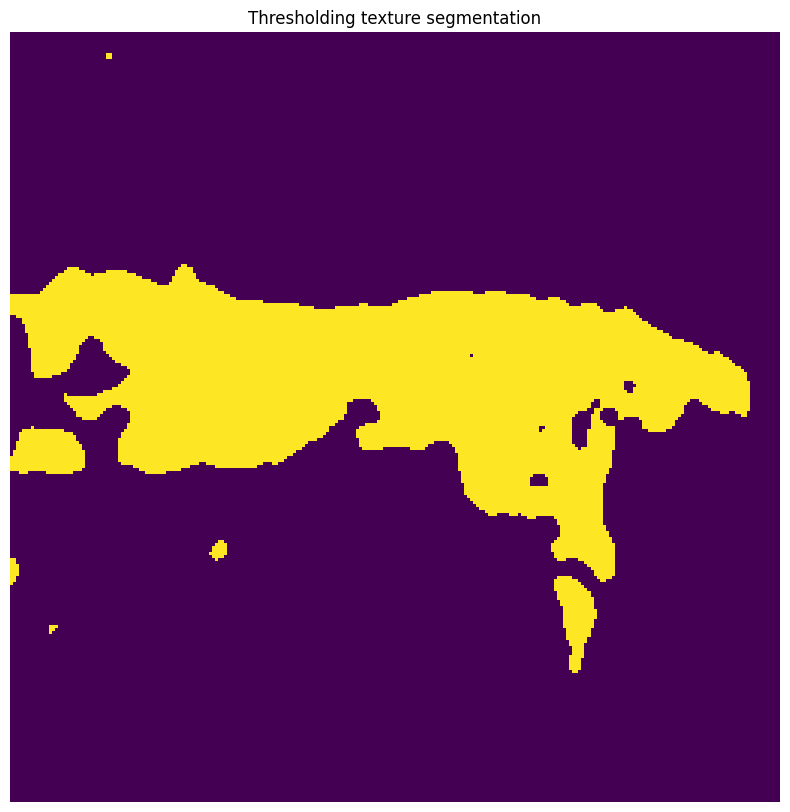

In [62]:
# gau_img = cv2.GaussianBlur(img, (5,5), 10.0) # 5*5 kernal, 2 on each side. 2 = 1/5 * 10 = 1/5 * sigma
# gau_img = skimage.filters.gaussian(img, sigma=10, truncate=1/5)

import cv2

gau_img_energy = cv2.GaussianBlur(im_energy, ksize=(5, 5), sigmaX=15.0)
gau_img_contrast = cv2.GaussianBlur(im_contrast, ksize=(5, 5), sigmaX=15.0)
gau_img_correlation = cv2.GaussianBlur(im_correlation, ksize=(5, 5), sigmaX=15.0)
gau_img_homogeneity = cv2.GaussianBlur(im_homogeneity, ksize=(5, 5), sigmaX=15.0)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(gau_img_energy)
plt.title("Blured Energy")
plt.subplot(222)
plt.imshow(gau_img_contrast)
plt.title("Blured Contrast")
plt.subplot(223)
plt.imshow(gau_img_correlation)
plt.title("Blured Correlation")
plt.subplot(224)
plt.imshow(gau_img_homogeneity)
plt.title("Blured Homogeneity")

segmentation = np.logical_and(gau_img_energy < 0.15, gau_img_contrast > 1200)
plt.figure(figsize=(10, 10))
plt.title('Thresholding texture segmentation')
plt.axis('off')
plt.imshow(segmentation)

# Texture segmentation by clustering
We were able to segment the jaguar based on its specific texture. In general, however, we describe the texture with several attributes - symptoms. It would be convenient to automatically segment the image into areas with different textures. For this purpose we will now use a simple method for clustering. The goal of clustering is to divide the feature space into regions where samples with similar properties are found. We implement a simple proprietary algorithm based on the principle "winner takes all" (Winner Takes All, WTA). First, we define the set of samples and the parameters of the algorithm:

<ipython-input-64-b55a8911af8b>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[x, y] = indx[0]


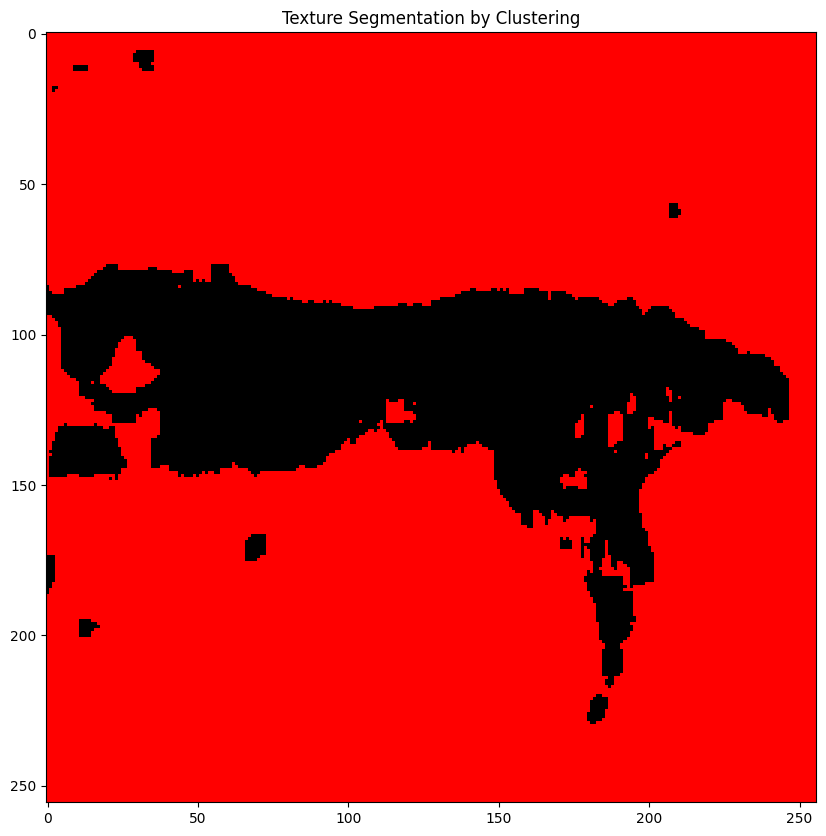

In [64]:
# Create new variables for normalized energy and contrast
normalized_energy = im_energy / np.max(im_energy)
normalized_contrast = im_contrast / np.max(im_contrast)

# Create feature vectors for clustering
energy = np.expand_dims(normalized_energy, axis=2)
contrast = np.expand_dims(normalized_contrast, axis=2)

X = np.concatenate((energy, contrast), axis=2)

# Define clustering parameters
n_iter = 5
n_centers = 2
alfa = 0.07

# Initialize random cluster centers
centers = np.random.rand(n_centers, X.shape[2])

# Perform clustering using the Winner Takes All (WTA) algorithm
for i in range(n_iter):
    for x in np.random.permutation(X.shape[0]):
        for y in np.random.permutation(X.shape[1]):
            item = X[x, y]
            distances = centers - np.tile(item, (n_centers, 1))
            distances = np.sum((distances ** 2), axis=1)
            min_distance = np.min(distances)
            indx = np.where(distances == min_distance)
            centers[indx] = (item - centers[indx]) * alfa + centers[indx]

# Create the segmentation output based on cluster indices
output = np.zeros(im_contrast.shape)
for x in range(X.shape[0]):
    for y in range(X.shape[1]):
        item = X[x, y]
        distances = centers - np.tile(item, (n_centers, 1))
        distances = np.sum((distances ** 2), axis=1)
        min_distance = np.min(distances)
        indx = np.where(distances == min_distance)
        output[x, y] = indx[0]

# Visualize the segmented image
plt.figure(figsize=(10, 10))
plt.title('Texture Segmentation by Clustering')
RGB_label = label2rgb(output)
plt.imshow(RGB_label)

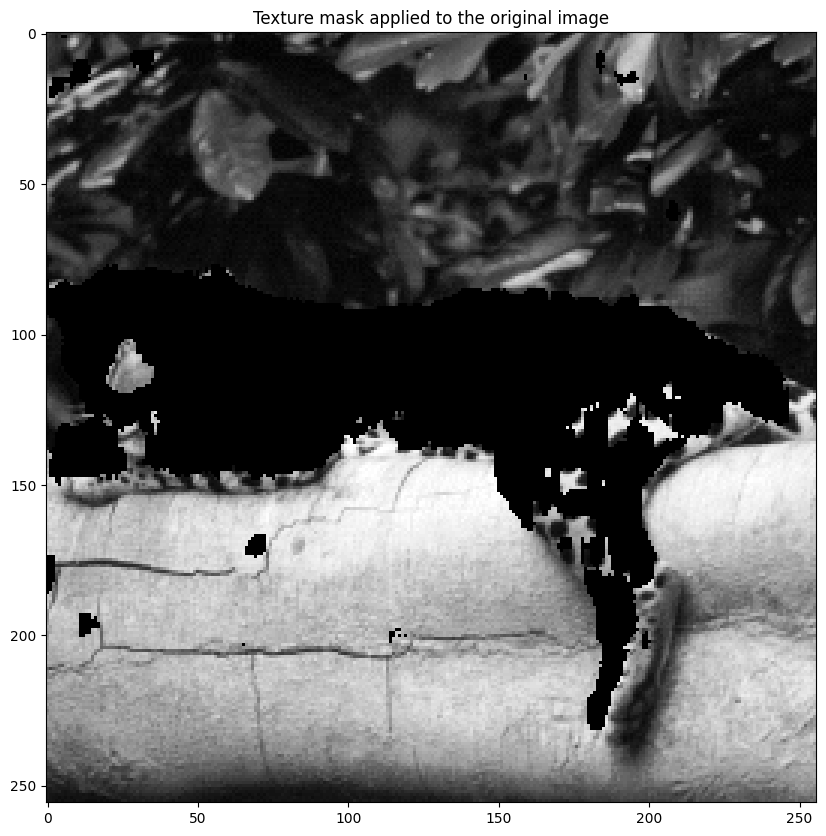

In [60]:
plt.figure(figsize=(10, 10))
plt.title('Texture mask applied to the original image')

# explain later :)
# chnl = RGB_label[:, :, 2]
# out = filters.threshold_otsu(chnl)
# mask = chnl < out
# finalMask = morphology.remove_small_holes(morphology.dilation(morphology.opening(RGB_label[:,:,1], morphology.disk(2)), morphology.disk(1)), 256)
# finalMask = morphology.remove_small_objects(finalMask, min_size= 100)

jaguar = img * (1 - output)
plt.imshow(jaguar, cmap='gray')

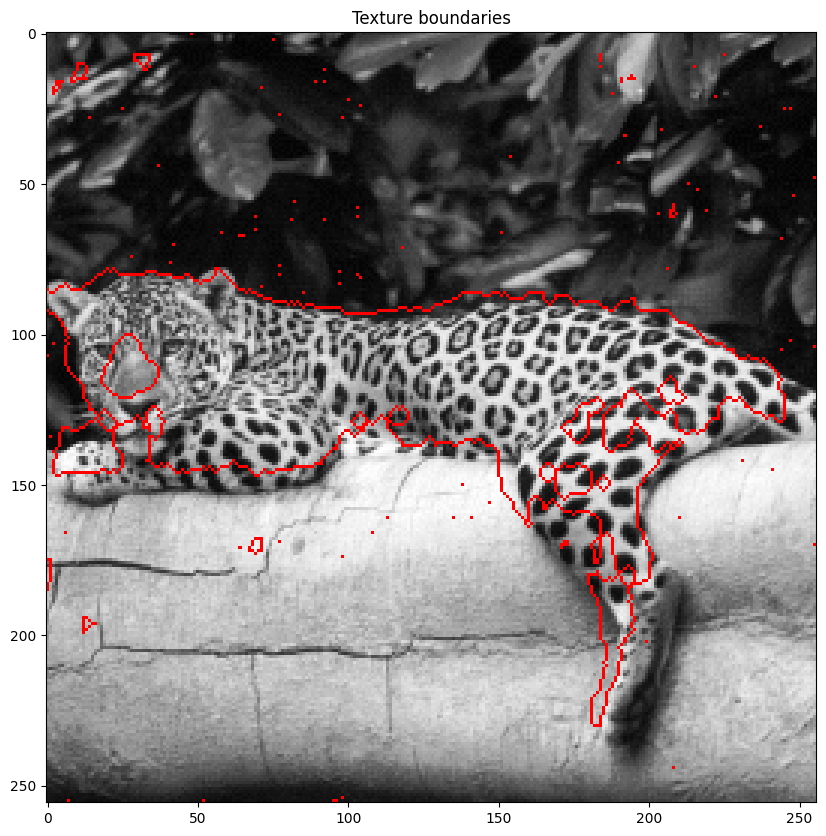

In [61]:
plt.figure(figsize=(10, 10))
plt.title("Texture boundaries")
boundary = find_boundaries(jaguar)
M_boundary = mark_boundaries(img, boundary, color = (1, 0, 0))
plt.imshow(M_boundary)

## Autonomous work 2

Change the texture segmentation by clustering so that the input vector of features can have an arbitrary length. Select the most suitable features (e.g. by calculating the co-occurrence matrix with different displacement vectors, different tile sizes, lowering the number of gray levels in the input image, etc.) so that you arrive at three textures when segmenting the image using clustering.

<ipython-input-91-99cfa14f534b>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[x] = indx[0]


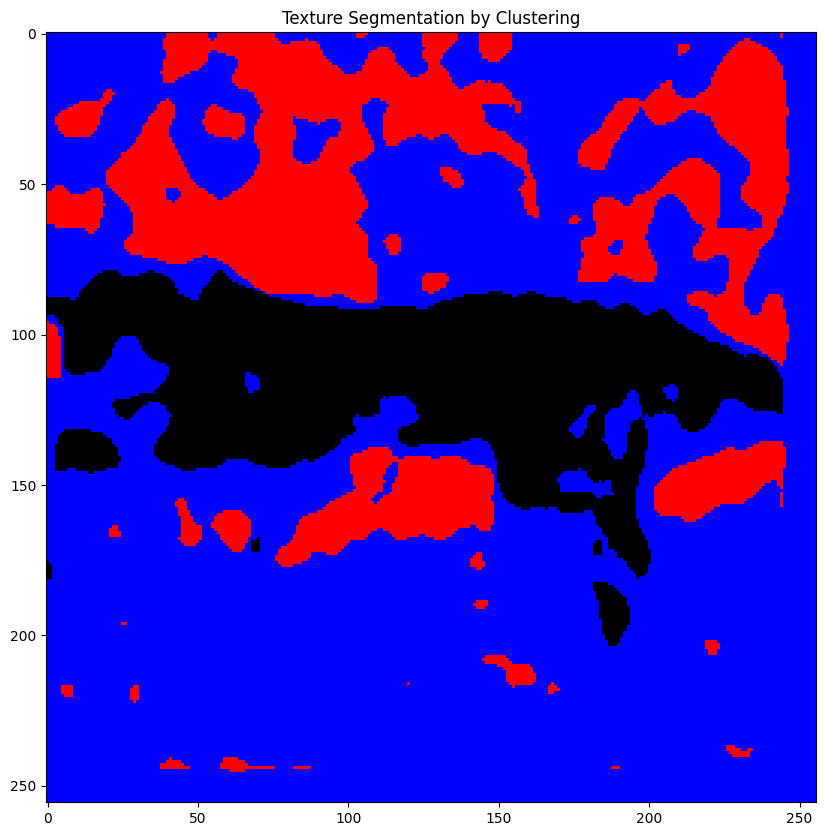

In [91]:
# Create new variables for normalized energy and contrast
normalized_energy = gau_img_energy / np.max(gau_img_energy)
normalized_contrast = gau_img_contrast / np.max(gau_img_contrast)
normalized_correlation = gau_img_correlation / np.max(gau_img_correlation)
normalized_homogeneity = gau_img_homogeneity / np.max(gau_img_homogeneity)

# Create feature vectors for clustering
energy = normalized_energy.flatten()
contrast = normalized_contrast.flatten()
correlation = normalized_contrast.flatten()
homogeneity = normalized_homogeneity.flatten()
X = np.vstack((energy, contrast, correlation, homogeneity)).T

# Define clustering parameters
n_iter = 5
n_centers = 3
alfa = 0.105

# Initialize random cluster centers
centers = np.random.rand(n_centers, X.shape[1])

# Perform clustering using the Winner Takes All (WTA) algorithm
for i in range(n_iter):
    for x in np.random.permutation(X.shape[0]):
          item = X[x]
          distances = centers - np.tile(item, (n_centers, 1))
          distances = np.sum((distances ** 2), axis=1)
          min_distance = np.min(distances)
          indx = np.where(distances == min_distance)
          centers[indx] = (item - centers[indx]) * alfa + centers[indx]

# Create the segmentation output based on cluster indices
height, width = im_contrast.shape
output = np.zeros(height * width)
for x in range(X.shape[0]):
        item = X[x]
        distances = centers - np.tile(item, (n_centers, 1))
        distances = np.sum((distances ** 2), axis=1)
        min_distance = np.min(distances)
        indx = np.where(distances == min_distance)
        output[x] = indx[0]

output_images = output.reshape(height, width)

# Visualize the segmented image
plt.figure(figsize=(10, 10))
plt.title('Texture Segmentation by Clustering')
RGB_label = label2rgb(output_images)
plt.imshow(RGB_label)

In [66]:
X

array([[0.2720793 , 0.08909683, 0.08909683, 0.16975878],
       [0.26877238, 0.09469077, 0.09469077, 0.17815441],
       [0.25697317, 0.10584948, 0.10584948, 0.16288758],
       ...,
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [73]:
X.shape

(65536, 4)

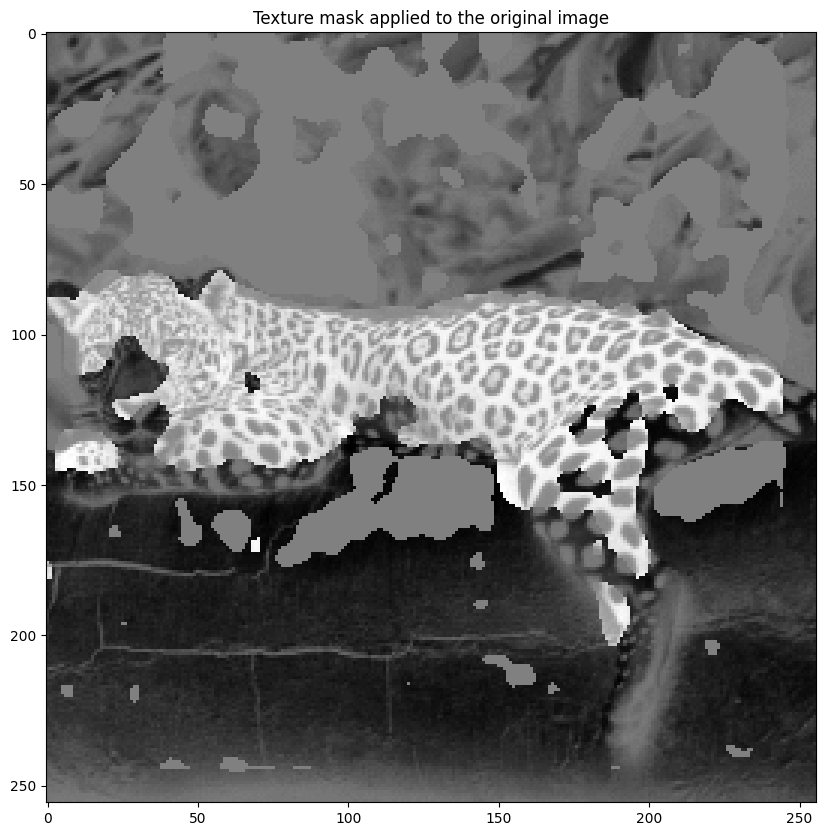

In [92]:
plt.figure(figsize=(10, 10))
plt.title('Texture mask applied to the original image')

jaguar = img * (1 - output_images)
plt.imshow(jaguar, cmap='gray')

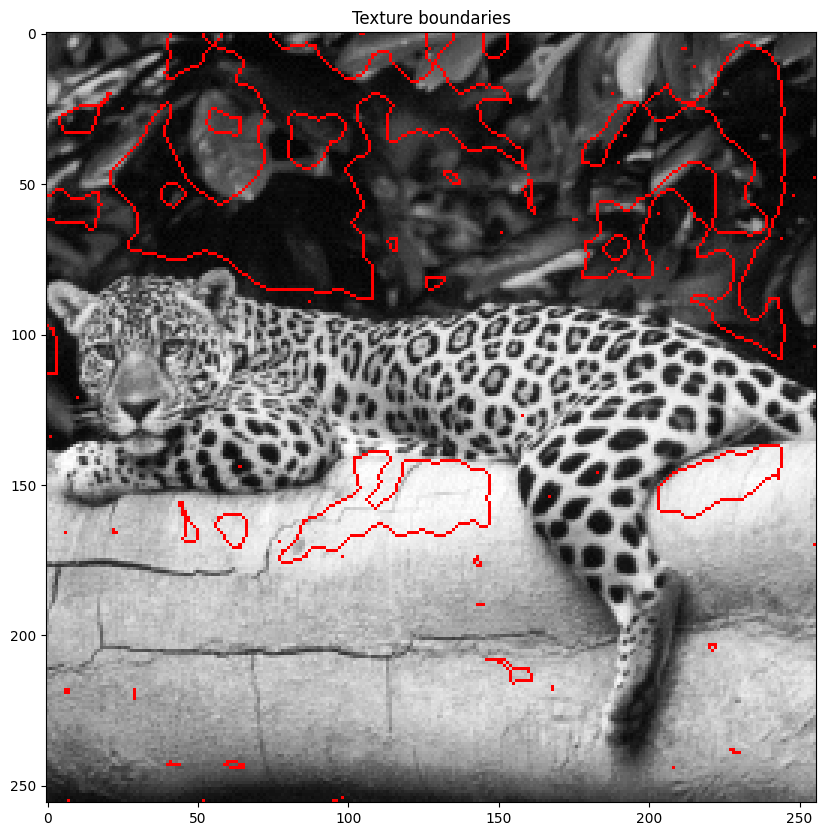

In [94]:
plt.figure(figsize=(10, 10))
plt.title("Texture boundaries")
boundary = find_boundaries(jaguar)
M_boundary = mark_boundaries(img, boundary, color = (1, 0, 0))
plt.imshow(M_boundary)